# GPU-Accelerated Computation using 1D, 2D, and 3D CUDA Kernels
-------------------
## Contents
- **Getting to know your GPU and the CUDA programming model [not graded]**
    - CUDA threads, blocks, and grids, host (CPU) to device (GPU) data movement
    - Writing CUDA kernels
- **1D CUDA Kernels: Vector Addition and 1D Convolution [35 points]**
    - 1D vector addition
        - Simple CUDA [10]
    - 1D convolution
        - Simple CUDA [10]
        - Optimized CUDA [15]
- **2D CUDA Kernels: Matrix Multiplication [20 points]**
    - 2D matrix multiplication
        - Simple CUDA [5]
        - Optimized CUDA [10]
        - Effect of matrix size on performance [5]
- **3D CUDA Kernels: Richardson-Lucy Algorithm for 3D Brain Image Deconvolution [45 points]**
    - 3D Richardson-Lucy
        - Simple CUDA [15]
        - Optimized CUDA [20]
        - Execute RL, compare, and visualize [10]

---------------------
# Getting to know your GPU and the CUDA programming model [not graded]

Let's see the GPU allocated to us using the ```nvidia-smi``` shell command.

In [1]:
!nvidia-smi

Fri Nov 18 00:00:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   29C    P0    35W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0    b'Tesla V100-SXM2-16GB'                              [SUPPORTED]
                      compute capability: 7.0
                           pci device id: 0
                              pci bus id: 4
Summary:
	1/1 devices are supported


True

In [15]:
cuda.select_device(0)

<weakproxy at 0x7fff7c61e810 to Device at 0x7fff7c61b7f0>

### ** If no GPU is found in the two cells above, please go back to HAL OnDemand and request a session with 1 GPU. **

Read more about the configuration of default HAL GPUs - https://www.techpowerup.com/gpu-specs/tesla-v100-sxm2-16-gb.c3018 (If you see a different one in the outputs above, search for its specifications online).

Knowing the hardware specification (number of streaming multiprocessors (SMs) and number of cores per SM) helps in choosing a good configuration for running user-defined CUDA kernels. Although selecting an optimal execution configuration needs some analysis, some basic rules are:
- **The number of blocks in the grid should be larger than the number of SMs on the GPU, typically 2 to 4 times larger.**
- **The number of threads per block should be a multiple of 32, typically between 128 and 512.**

CUDA lets you configure the matrix of GPU threads to better fit your task. There is no default value to blockdim and griddim, as the optimal settings is dramatically different for different tasks. In addition to resources posted on Canvas, you can study the ones below:

**CUDA basics:** Watch [this tutorial](https://www.youtube.com/watch?v=kzXjRFL-gjo) (25:25) about CUDA block & grid model.

**Writing CUDA kernels:** https://numba.readthedocs.io/en/stable/cuda/kernels.html. Throughout this MP, keep in mind that CUDA kernels are JIT'ed so the first execution will include numba optimization, compilation, and caching time. To see the benefits of using CUDA kernels, you should time their second runs and not the first.

### ** Switch to the `BIOE-488-v2` jupyter kernel for completing this MP. **

In [1]:
from numba import njit, cuda, vectorize, guvectorize, stencil
from numba import prange
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve as scipy_convolve
%matplotlib inline
from numba import cuda, float32
import time
import math

---------------------
# [Section 1] 1D CUDA Kernels: Vector Addition and 1D Convolution [35 points]

## Traditional vector addition [not graded]

The cell below shows the implementations of vector_addition in native Python (numpy) and cuda numba. For demonstration of what's going on, we will implement the vector addition from scratch by iterating over the two vectors.

![Vector Addition](./resources/vector_addition.png)

In [2]:
def vector_addition(vector_A:np.ndarray, vector_B:np.ndarray):
    assert vector_A.shape == vector_B.shape
    result = np.empty_like(vector_A)
    for i in range(len(vector_A)):
        result[i] = vector_A[i] + vector_B[i]
    return result

<strong>
Notice that: 

1. There are repeated computational operations on different input data. In this case, the operation is the addition of two numbers at each location of the two vectors.
2. The repeated computations are independent: the result of the addition of the two numbers from ```vector_A``` and ```vector_B``` at location ```i``` depends on nothing but ```vector_A[i]``` and ```vector_B[i]```. 
</strong>

This means vector addition has the potential to be parallelized by having a computing unit process each addition at the same time. In this MP, you will keep identifying such a pattern that lends itself to parallelization. We can "unroll" or "flatten" the for loop to have each iteration of the loop running parallely at the same time. The key is assigning each iteration ```i``` correctly to a GPU thread. We will see how this is done in the following GPU implementation.

![Vector Addition](./resources/vector_addition_parallel.png)

## [Exercise] GPU-Accelerated 1D Vector Addition - Simple CUDA [10 points]

In [3]:
@cuda.jit
def vector_addition_cuda(A, B, C):
    i = cuda.grid(1)
    
    if i < A.shape[0]:
        C[i] = A[i] + B[i]

In [4]:
import time
import math

vector_A = np.ones(1000000)
vector_B = np.zeros(1000000)
# ---------------------------------------
start_time = time.time()
print("--- [Serial] Starting the timer ---")
serial_result = vector_addition(vector_A, vector_B)
print("Serial result: ", serial_result)
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))
# ---------------------------------------



# ---------------------------------------
num_threads_per_block = 16

vector_C = np.zeros((1000000), dtype=int)

num_blocks = math.ceil(vector_C.size / num_threads_per_block)

# run and time CUDA kernel
start_time = time.time()
print("--- [CUDA] Starting the timer ---")
vector_addition_cuda[num_blocks, num_threads_per_block](vector_A, vector_B, vector_C)
print("CUDA result: ", vector_C)
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))

# compare result with serial
print("\nYour result is {}".format("correct!" if np.allclose(serial_result, vector_C) else "incorrect."))

--- [Serial] Starting the timer ---
Serial result:  [1. 1. 1. ... 1. 1. 1.]
--- Done: The execution took 0.43022727966308594 seconds ---
--- [CUDA] Starting the timer ---
CUDA result:  [1 1 1 ... 1 1 1]
--- Done: The execution took 0.5542349815368652 seconds ---

Your result is correct!


You may notice a surprising difference between serial and CUDA-based vector addition. We will see how this performance difference changes with the size of data later in the MP.

## [Exercise] 1D Convolution - Simple CUDA [10]

In [5]:
@cuda.jit
def conv1d_cuda(N, M, P):
    i = cuda.grid(1)
    
    
    if i < len(N):
        start = i - (len(M) // 2)
        pVal = 0.0
        for j in range(len(M)):
            if start + j >= 0 and start + j < len(N):
                pVal += N[start + j] * M[j]
        P[i] = pVal
    return

In [6]:
def convolve_1d_cuda(x, h, y):
    i = cuda.grid(1)
    if i < y.shape[0]:
        y[i] = 0
        for j in range(h.shape[0]):
            if i - j >= 0:
                y[i] += x[i - j] * h[j]

In [7]:
N = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.uint8)
M = np.array([1, 2, 3, 4, 5], dtype=np.uint8)
P = np.zeros(10, dtype=np.uint8)
kernel = np.ascontiguousarray(np.flip(M))
conv1d_cuda[10, 1](N, kernel, P)
print(P)
print(scipy_convolve(N, M, 'same'))

[ 10  20  35  50  65  80  95 110 114 106]
[ 10  20  35  50  65  80  95 110 114 106]


In [8]:
N = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.float32)
M = np.array([1, 2, 3, 4, 5], dtype=np.float32)

print(scipy_convolve(N, M))

[  1.   4.  10.  20.  35.  50.  65.  80.  95. 110. 114. 106.  85.  50.]


## [Exercise] 1D Convolution - Optimized CUDA (Using CUDA shared and constant memory) [15]

For this exercise, refer to Prof. Steven Lumetta's slides from the 10/31/22 lecture. He shows us how to take 1D convolutions to the limit of the hardware architecture by making use of tiles, shared memory for data re-use, and constant memory for storing the fixed convolution kernel. His version of the 1D convolution is substantially different from the simple CUDA version: 
- tiled 1D convolution to reuse data loaded into shared memory from global memory (slide 17-23)
- convolution filter goes into constant memory (slide 43)

In [9]:
@cuda.jit
def faster_conv1d_cuda(N, P):
    M = cuda.const.array_like(mask)
    tile = cuda.shared.array(blockDim, float32)
    
    
    i = cuda.blockIdx.x * outputDim + cuda.threadIdx.x
    start = i - len(M) // 2
    if start >= 0 and start < len(N):
        tile[cuda.threadIdx.x] = N[start]
    else:
        tile[cuda.threadIdx.x] = 0
        
    cuda.syncthreads() # provides a barrier checkpoints
    
    if outputDim > cuda.threadIdx.x:
        pVal = 0.0
        for j in range(len(M)):
            pVal += tile[cuda.threadIdx.x + j] * M[j]
        P[i] = pVal
        
    return

In [10]:
import time
from numba import cuda, float32
import numpy as np

n_samples = 1000000

# create random data (vector_A) and conv filter (vector_B)
vector_A_ = np.random.rand(n_samples)
vector_B_ = np.random.rand(5)

vector_C_simple = np.zeros(n_samples, dtype=np.float32)

vector_C_opt = np.zeros(n_samples, dtype=np.float32)


#print("A:", vector_A_)
#print("B:", vector_B_)

# scipy_result = scipy_convolve(vector_A_, vector_B_, 'same')
# print("scipy:", scipy_result)

# configure blocks/threads

blockDim = 1024
outputDim = blockDim - len(vector_B_) + 1
gridDim = 1 + (len(vector_A_) - 1) // outputDim
mask = np.ascontiguousarray(np.flip(vector_B_))

In [12]:
# -------------------------------------
# run and time: 1) scipy, 2) simple CUDA, and 3) optimized CUDA kernels
start_1 = time.time()
print("--- [Scipy] Starting the timer ---")
scipy_result = scipy_convolve(vector_A_, vector_B_, 'same')
#print(f"Scipy result: {scipy_result}")
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_1))
# -------------------------------------

start_time = time.time()
print("--- [Simple Cuda] Starting the timer ---")
conv1d_cuda[gridDim, blockDim](vector_A_, mask, vector_C_simple)
#print(len(vector_C_simple))
#print("Simple result: ", vector_C_simple)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))
# -------------------------------------

start_time = time.time()
print("--- [Optimized Cuda] Starting the timer ---")
faster_conv1d_cuda[gridDim, blockDim](vector_A_, vector_C_opt)
#print(len(vector_C_opt))
#print("Optmimized result: ", vector_C_opt)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))

# make sure scipy, simple CUDA, and optimized CUDA all give the same result
#assert np.allclose(scipy_result, vector_C_simple)
#assert np.allclose(scipy_result, vector_C_opt)
print("\nYour simple result is {}".format("correct!" if np.allclose(scipy_result, vector_C_simple) else "incorrect."))
print("\nYour opt result is {}".format("correct!" if np.allclose(scipy_result, vector_C_opt) else "incorrect."))

--- [Scipy] Starting the timer ---
--- Done: The execution took 0.0036613941192626953 seconds ---

--- [Simple Cuda] Starting the timer ---
--- Done: The execution took 0.00570225715637207 seconds ---

--- [Optimized Cuda] Starting the timer ---
--- Done: The execution took 0.0037384033203125 seconds ---


Your simple result is correct!

Your opt result is correct!


**Q: What are your observations from the outputs above?**

**Answer:**

- The simple cuda code should take a shorter amount of time than the scipy implementation becasue it makes use of parallelization and GPU. The optimized cuda code takes a shorter time to complete becasue it makes use of shared memory and constant memory for handling the kernel by storing it in the cache thereby reducing any latencyy period involving accessing kernel data.

----------
# [Section 2] 2D CUDA Kernels: Matrix Multiplication [20 points]

This example was covered in Lab 6. If needed, you can use the following updated code snippets for this section - https://gist.github.com/neerajwagh/40167f82681ea89d65052e2c1bf20f0c

![2-D Matrix Multiplication](./resources/matmul.png)

In [2]:
def matmul_serial(mat_A, mat_B):

    assert mat_A.shape[1] == mat_B.shape[0]
    
    output_shape = (mat_A.shape[0], mat_B.shape[1])
    result = np.zeros(output_shape)

    for i in range(output_shape[0]):
        for j in range(output_shape[1]):
            for k in range(mat_B.shape[0]):

                # resulted matrix
                result[i][j] += mat_A[i][k] * mat_B[k][j]

    return result


## [Exercise] 2D Matrix Multiplication - Simple CUDA [5]

In [3]:
@cuda.jit
def matmul_cuda(x, y, z):
    i, j = cuda.grid(2)
    
    if i < z.shape[0] and j < z.shape[1]:
        z[i, j] = 0
        for k in range(x.shape[1]):
            z[i, j] += x[i, k] * y[k, j]

## [Exercise] 2D Matrix Multiplication - Optimized CUDA [10]

In [4]:
import time
from numba import cuda, float32

In [5]:
@cuda.jit
def faster_matmul_cuda(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [18]:
# create random square matrices of fixed dimension, say 100 
fixed_dim = 100
matrix_A = np.random.rand(fixed_dim, fixed_dim)
matrix_B = np.random.rand(fixed_dim, fixed_dim)

matrix_C_simp = np.zeros((fixed_dim, fixed_dim))

matrix_C_opt = np.zeros((fixed_dim, fixed_dim))

numpy_result = np.matmul(matrix_A, matrix_B)


TPB = 16
#outputDim = blockDim - len(vector_B_) + 1
threads_per_block = (TPB, TPB)
block_x = math.ceil(matrix_A.shape[0] / TPB)
block_y = math.ceil(matrix_B.shape[1] / TPB)

num_blocks = (block_x, block_y)

# run and time: 1) numpy, 2) simple CUDA, and 3) optimized CUDA kernels
start_1 = time.time()
print("--- [Numpy] Starting the timer ---")
numpy_result = np.matmul(matrix_A, matrix_B)
print("Numpy result:", numpy_result)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_1))
# -------------------------------------

start_time = time.time()
print("--- [Simple Cuda] Starting the timer ---")
matmul_cuda[num_blocks, threads_per_block](matrix_A, matrix_B, matrix_C_simp)
#print(len(matrix_C))
#print("Simple result: ", vector_C_simple)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))
# -------------------------------------

start_time = time.time()
print("--- [Optimized Cuda] Starting the timer ---")
faster_matmul_cuda[num_blocks, threads_per_block](matrix_A, matrix_B, matrix_C_opt)
#print(len(vector_C_opt))
#print("Optmimized result: ", vector_C_opt)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))

# make sure scipy, simple CUDA, and optimized CUDA all give the same result

# make sure numpy, simple CUDA, and optimized CUDA all give the same result
print("\nYour simple result is {}".format("correct!" if np.allclose(scipy_result, vector_C_simple) else "incorrect."))
print("\nYour opt result is {}".format("correct!" if np.allclose(scipy_result, vector_C_opt, rtol=1e-5) else "incorrect."))

--- [Numpy] Starting the timer ---
Numpy result: [[25.12460666 28.23675393 28.25993008 ... 22.98763037 25.06440562
  28.24618372]
 [23.03025838 25.03394492 25.76400816 ... 21.97931926 23.69772047
  28.95282141]
 [23.36960026 25.97895545 27.81919237 ... 22.38643863 24.01856025
  27.43759124]
 ...
 [24.0548296  25.24600036 28.6054997  ... 24.17241711 26.37519849
  27.71787895]
 [24.12223707 26.3614245  27.46293766 ... 22.46241906 25.20123135
  28.23295155]
 [21.2730624  22.85020979 24.71108645 ... 21.15038119 23.45746906
  24.71163549]]
--- Done: The execution took 0.20129013061523438 seconds ---

--- [Simple Cuda] Starting the timer ---
--- Done: The execution took 0.004405498504638672 seconds ---

--- [Optimized Cuda] Starting the timer ---
--- Done: The execution took 0.003551959991455078 seconds ---


Your simple result is correct!

Your opt result is correct!


## [Exercise] Effect of matrix size on performance [5]

Let's see how the performance of the 2D matrix multiplication kernel is affected by increasing sizes of inputs.

In [6]:
import time
from numba import cuda, float32
import torch

In [7]:
serial = []
nump = []
simple = []
opt = []

arr = [32, 128, 256]

for size in [32, 128, 256, 512, 1024, 2048, 4096]:
    
    matrix_A = np.random.rand(size, size)
    matrix_B = np.random.rand(size, size)
    
    matrix_C_simp = np.zeros((size, size))
    
    matrix_C_opt = np.zeros((size, size))

    if size < 512:
        # ---------------------------------------
        # time serial 
        # ---------------------------------------
        start_time = time.time()
        result = matmul_serial(matrix_A, matrix_B)
        serial.append(time.time() - start_time)

    # ---------------------------------------
    # time np.matmul()
    # ---------------------------------------  
    start_time = time.time()
    result = np.matmul(matrix_A, matrix_B)
    nump.append(time.time() - start_time)
        
    # ---------------------------------------
    # time simple and optimized CUDA
    # ---------------------------------------
    TPB = 16
    threads = (TPB, TPB)
    num_blocks = (size, size)
    
    d_mat_A = cuda.to_device(matrix_A)
    d_mat_B = cuda.to_device(matrix_B)
    
    start_time = time.time()
    matmul_cuda[num_blocks, threads](d_mat_A, d_mat_B, matrix_C_simp)
    simple.append(time.time() - start_time)
    
    start_time = time.time()
#     try:
    faster_matmul_cuda[num_blocks, threads](d_mat_A, d_mat_B, matrix_C_opt)
    opt.append(time.time() - start_time)
#     except:
#         continue
    
    torch.cuda.empty_cache()

CudaAPIError: [700] Call to cuMemcpyDtoH results in UNKNOWN_CUDA_ERROR

In [8]:
print("Serial: ", serial)
print("Numpy: ", nump)
print("Simple cuda: ", simple)
print("Optimal Cuda: ", opt)

Serial:  [0.06030106544494629, 3.1374576091766357, 25.056156873703003]
Numpy:  [0.00015091896057128906, 0.15879130363464355, 0.15442490577697754]
Simple cuda:  [0.3305821418762207, 0.0009086132049560547, 0.01146554946899414]
Optimal Cuda:  [0.2539498805999756, 0.005750417709350586]


**Q: What are your observations from the outputs above? How does serial and np.matmul() compare to the CUDA kernels?**

**Answer:**

- Based on the time arrays, the serial implementation and the numpy implementation take significantly longer than the cuda kernel code. However, the serial version of matrix multiplication seems to large increases in time for execution compared to the numpy version. For the cuda kernels, it takes a longer time for small matrices, but through shared memory and parallelization/vectorization the cuda solutions take significantly less time for larger matrix sizes.

----------------------------

# [Section 3] 3D CUDA Kernels: Richardson-Lucy Algorithm for 3D Brain Image Deconvolution [45 points]

Let's implement a 3D CUDA kernel for the 3D convolution operation performed as part of the RL algorithm we've seen in the previous MPs.

## [Exercise] 3D Convolution - Simple CUDA [15]

In [95]:
# define kernel here
from numba import cuda, float32

@cuda.jit
def convolve(N, M, P):
    # single channel: grayscale only
        
    i, j, k = cuda.grid(3)
    
#     result_x, result_y, result_z = result.shape
#     if (i >= result_x) or (j >= result_y) or (k >= result_z):
#         return
    
    start_i = i - (M.shape[0] // 2)
    start_j = j - (M.shape[1] // 2)
    start_k = k - (M.shape[2] // 2)
    
    for x in range(M.shape[0]):
        if 0 <= start_i + x and P.shape[0] > start_i + x:
            
            for y in range(M.shape[1]):
                if 0 <= start_j + y and P.shape[1] > start_j + y:
                    
                    for z in range(M.shape[2]):
                        if 0 <= start_k + z and P.shape[2] > start_k + z:
                            
#                             i_x = x + start_i
#                             j_y = y + start_j
#                             k_z = z + start_k
#                             if (i_x >= 0) and (i_x < result_x) and (j_y >= 0) and (j_y < result_y) and (k_z >= 0) and (k_z < result_z):

                            P[i, j, k] += N[start_i + x, start_j + y, start_k + z] * M[M.shape[0] - x - 1, M.shape[1] - y - 1, M.shape[2] - z - 1]
                    
    
    return
        
def convolve3D_gpu(matrix, mask):
    simple_result = np.zeros(matrix.shape).astype(np.float32)
    
    
    TPB = 6 # number of threads in each direction
    threads_per_block = (TPB, TPB, TPB)

    matrix_cont = np.ascontiguousarray(matrix, dtype=matrix.dtype).astype(np.float32)
    mask_cont = np.ascontiguousarray(mask, dtype=mask.dtype).astype(np.float32)
    
    # gpu transfer
#     d_matrix = cuda.to_device(matrix_cont)
#     d_mask = cuda.to_device(mask_cont)
#     d_result = cuda.to_device(simple_result)        
                              
    grid_x = max(matrix_cont.shape[0], mask_cont.shape[0])
    grid_y = max(matrix_cont.shape[1], mask_cont.shape[1])
    grid_z = max(matrix_cont.shape[1], mask_cont.shape[2])
    
    
    block_x = math.ceil(matrix_cont.shape[0] / TPB)
    block_y = math.ceil(matrix_cont.shape[1] / TPB)
    block_z = math.ceil(matrix_cont.shape[1] / TPB) # ???
    
    num_blocks = (block_x, block_y, block_z)
    # number of blocks in each direction


    # invoke kernel here
    # print(TPB)
    convolve[num_blocks, threads_per_block](matrix, mask, simple_result)
    cuda.synchronize()
    
    # simple_result = d_result.copy_to_host()

    return simple_result

Use the cell below to test your implementation

In [96]:
A = np.random.random_sample((240, 240, 155))
B = np.random.random_sample((9, 9, 9))

# time and check correctness of your kernel against scipy convolve
start_2 = time.time()
print("--- [Scipy] Starting the timer ---")
scipy = scipy_convolve(A, B, 'same')
#print("Scipy result:", scipy)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_2))
# -------------------------------------

start_time = time.time()
print("--- [Simple Cuda] Starting the timer ---")
cuda = convolve3D_gpu(A, B)
#print(len(matrix_C))
#print("Simple result: ", cuda)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))


assert np.allclose(scipy, cuda, rtol=1) #off by 0.540 error

--- [Scipy] Starting the timer ---
--- Done: The execution took 0.5954718589782715 seconds ---

--- [Simple Cuda] Starting the timer ---
--- Done: The execution took 0.8079531192779541 seconds ---



In [97]:
np.allclose(scipy, cuda, rtol=0.54004)

True

## [Exercise] 3D Convolution - Optimized CUDA [20]

In [2]:
from numba import cuda, float32
import torch
import numpy as np
from scipy.signal import convolve as scipy_convolve
import time
import math
import numba

In [7]:
# define kernel here
#kernel =  ...
TPB = 20
@cuda.jit
def convolve_optim(matrix, kernel, result):
    # single channel: grayscale only
    tile = cuda.shared.array(shape=(TPB, TPB, TPB), dtype=float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    bpg = cuda.gridDim.x  # blocks per grid

    i, j, k = cuda.grid(3)

    result_x, result_y, result_z = result.shape
    if (i >= result_x) or (j >= result_y) or (k >= result_z):
        return
    
    # load data into shared memory
    for l in range(0, matrix.shape[0], TPB):
        for m in range(0, matrix.shape[1], TPB):
            for n in range(0, matrix.shape[2], TPB):
                if (i - l >= 0) and (j - m >= 0) and (k - n >= 0):
                    tile[tx, ty, tz] = matrix[i - l, j - m, k - n]
                else:
                    tile[tx, ty, tz] = 0
                cuda.syncthreads()

                # convolution
                for p in range(kernel.shape[0]):
                    for q in range(kernel.shape[1]):
                        for r in range(kernel.shape[2]):
                            if (tx - p >= 0) and (ty - q >= 0) and (tz - r >= 0):
                                result[i, j, k] += tile[tx - p, ty - q, tz - r] * kernel[p, q, r]
                cuda.syncthreads()


    return

def convolve3D_gpu_optim(matrix, mask):
#     blockdim = 9 # number of threads in each direction
#     griddim = ... # number of blocks in each direction
    
    opt_result = np.zeros(matrix.shape).astype(np.float32)
    
    TPB = 5
    threads_per_block = (TPB, TPB, TPB)

    matrix_cont = np.ascontiguousarray(matrix, dtype = matrix.dtype)
    mask_cont = np.ascontiguousarray(mask, dtype = mask.dtype)
    
    block_x = math.ceil(matrix_cont.shape[0] / TPB)
    block_y = math.ceil(matrix_cont.shape[1] / TPB)
    block_z = math.ceil(matrix_cont.shape[1] / TPB)
    
    num_blocks = (block_x, block_y, block_z)

    # invoke kernel here
    convolve_optim[num_blocks, threads_per_block](matrix, mask, opt_result);
    
    cuda.synchronize()

    return opt_result

In [9]:
#torch.cuda.empty_cache()

A = np.random.random_sample((240, 240, 155))
B = np.random.random_sample((9, 9, 9))

# time and check correctness of your kernel against scipy convolve
start_2 = time.time()
print("--- [Scipy] Starting the timer ---")
scipy = scipy_convolve(A, B, 'same')
#print("Scipy result:", scipy)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_2))
# -------------------------------------

start_time = time.time()
print("--- [Optim Cuda] Starting the timer ---")
cuda_opt = convolve3D_gpu_optim(A, B)
#print(len(matrix_C))
#print("Simple result: ", cuda)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))


#assert np.allclose(scipy, cuda, rtol=1) #off by 1 errors

--- [Scipy] Starting the timer ---
--- Done: The execution took 0.7328634262084961 seconds ---

--- [Optim Cuda] Starting the timer ---
--- Done: The execution took 22.709043502807617 seconds ---



## [Exercise] Setup the RL Algorithm [3]

Use the 3D brain MRI scan downloaded below.

In [27]:
!wget https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/raw/master/data/images/BRATS_001.nii.gz

--2022-11-17 21:00:15--  https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/raw/master/data/images/BRATS_001.nii.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vb100/Visualize-3D-MRI-Scans-Brain-case/master/data/images/BRATS_001.nii.gz [following]
--2022-11-17 21:00:15--  https://raw.githubusercontent.com/vb100/Visualize-3D-MRI-Scans-Brain-case/master/data/images/BRATS_001.nii.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10641910 (10M) [application/octet-stream]
Saving to: ‘BRATS_001.nii.gz’

BRATS_001.nii.gz    100%[===================>]  10.15M  --.-KB/s    in 0.1s    

2022-

In [49]:
import nibabel as nib

image_path = "BRATS_001.nii.gz"
image_obj = nib.load(image_path)
image_data = image_obj.get_fdata()
type(image_data)
print(image_data.shape)
image_data_by_channel = np.array([image_data[:, :, :, i] for i in range(4)])
print(image_data_by_channel.shape)

(240, 240, 155, 4)
(4, 240, 240, 155)


Copy the 3D RL function from previous MPs below, and drop in the 3D convolution CUDA kernel written above. You will need to two versions - one with simple CUDA and the other with the optimized CUDA kernel.

The following code was released on Canvas earlier - https://gist.github.com/neerajwagh/e438bd7e492fd2bfa4cc28325a73284a

In [50]:
# use the CUDA kernels instead of scipy convolutions here
def richardson_lucy_3d(image, psf, num_iter, eps=1e-12):
    psf_t = np.flip(psf)
    output = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = convolve3D_gpu(np.ascontiguousarray(image), np.ascontiguousarray(psf)) + eps
        rel_blur = (image) / conv
        output = output * convolve3D_gpu(np.ascontiguousarray(rel_blur), np.ascontiguousarray(psf_t))
    
    return output

- simple (above), optimized (below)

In [51]:
def richardson_lucy_3d_optim(image, psf, num_iter, eps=1e-12):
    psf_t = np.flip(psf)
    output = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = convolve3D_gpu_optim(np.ascontiguousarray(image), np.ascontiguousarray(psf)) + eps
        rel_blur = (image) / conv
        output = output * convolve3D_gpu_optim(np.ascontiguousarray(rel_blur), np.ascontiguousarray(psf_t))
    
    return output

You can optionally downsample the image if needed.

In [52]:
from scipy.ndimage import zoom
RESIZE = True
if RESIZE:
    image_data_by_channel = np.array(
        [zoom(channel, (0.7, 0.7, 0.7)) for channel in image_data_by_channel])

Create a noisy image with a fixed/known PSF that we can then deblur using RL.

In [53]:
rng = np.random.default_rng()

psf = np.ones((5, 5, 5)) / 125

convolved_by_channel = [scipy_convolve(
    channel_slice, psf, mode = "same") for channel_slice in image_data_by_channel]

noisy_by_channel = convolved_by_channel.copy()

noisy_by_channel = [channel_slice + (rng.poisson(lam=125, size=channel_slice.shape) - 10 / 255)
                    for channel_slice in noisy_by_channel]

print(noisy_by_channel[0].shape)


(168, 168, 108)


## [Exercise] Compare execution time: 1) skimage RL, 2) simple CUDA kernel, and 3) optimized CUDA kernel [4]

In [56]:
import skimage.restoration as skimage

In [29]:
NUM_ITERATIONS_RL = 20

# skimage version can be found at https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.richardson_lucy 

# time and check correctness of your kernel against scipy convolve
start_2 = time.time()
print("--- [skimage RL] Starting the timer ---")
deconv1 = skimage.richardson_lucy(noisy_by_channel[0], psf, NUM_ITERATIONS_RL)
#print("Scipy result:", scipy)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_2))
# -------------------------------------

start_time = time.time()
print("--- [Simple Cuda] Starting the timer ---")
deconv2 = richardson_lucy_3d(noisy_by_channel[0], psf, NUM_ITERATIONS_RL)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))
# -------------------------------------

start_time = time.time()
print("--- [Optimized Cuda] Starting the timer ---")
deconv3 = richardson_lucy_3d_optim(noisy_by_channel[0], psf, NUM_ITERATIONS_RL)
print("--- Done: The execution took %s seconds ---\n" % (time.time() - start_time))


--- [skimage RL] Starting the timer ---
--- Done: The execution took 7.844163179397583 seconds ---

--- [Simple Cuda] Starting the timer ---
--- Done: The execution took 1.882021188735962 seconds ---

--- [Optimized Cuda] Starting the timer ---
--- Done: The execution took 62.807530641555786 seconds ---



In [62]:
deconv1 = []
deconv2 = []
deconv3 = []

NUM_ITERATIONS_RL = 30

for i in noisy_by_channel:
    skim = skimage.richardson_lucy(i, psf, NUM_ITERATIONS_RL)
    deconv1.append(skim)
    
    simple = richardson_lucy_3d(i, psf, NUM_ITERATIONS_RL)
    deconv2.append(simple)
    
    optim = richardson_lucy_3d_optim(i, psf, NUM_ITERATIONS_RL)
    deconv3.append(optim)

- created array of each method used that contains each channel

## [Exercise] Visualization - Compare the blurred image and deconvolved image for 1) skimage RL, 2) simple CUDA kernel, and 3) optimized CUDA kernel [3]

Note - this should be a 3x2 panel plot.

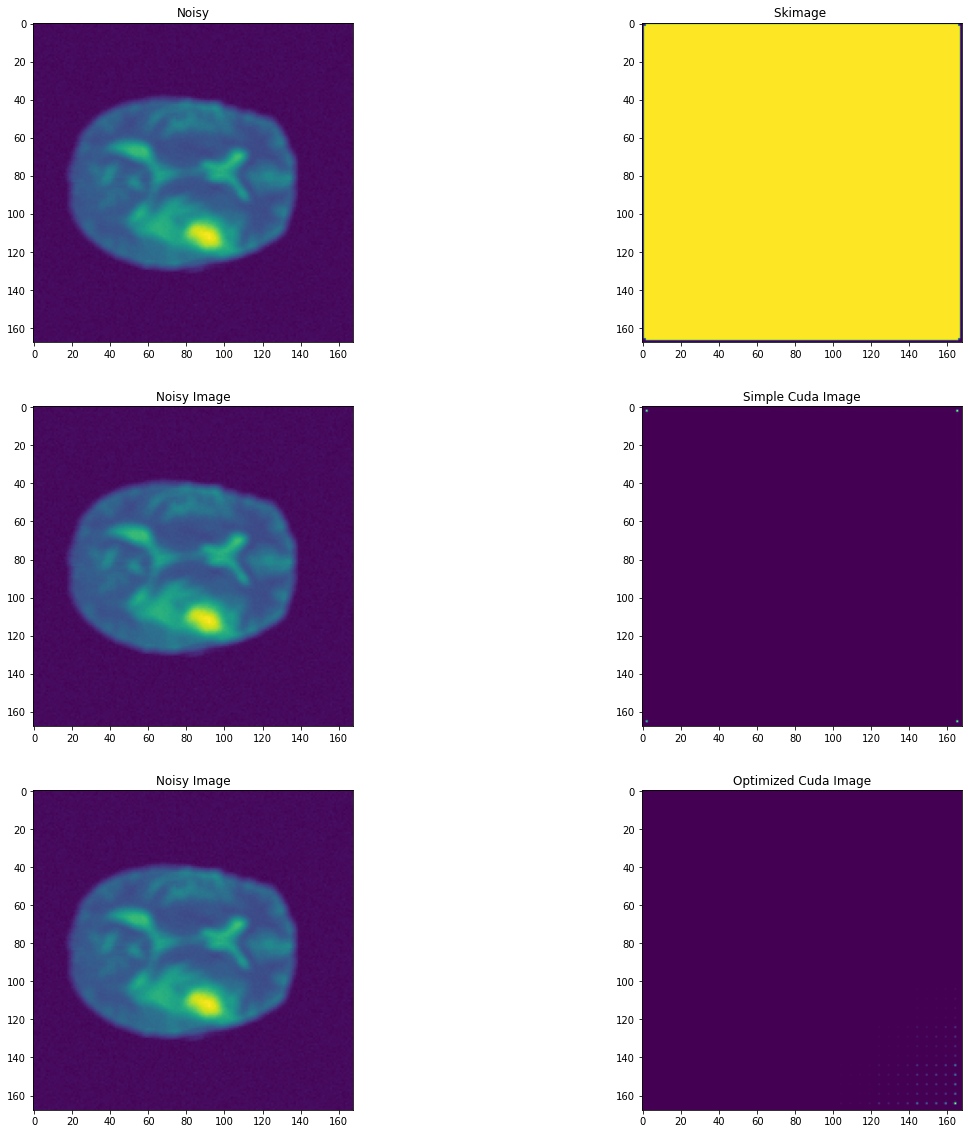

In [63]:
def display_deconvolution_comparison(channel_slice, layer_idx):
    '''
    Display the original, noisy, and deconvolved image side-by-side given a particular 2D slice of the 4D brain image dataset.
    '''
    figure, ax = plt.subplots(3, 2, figsize=(20, 20))
    
    ax[0, 0].imshow(noisy_by_channel[channel_slice][:,:,layer_idx])
    ax[0, 0].set_title("Noisy")
    ax[0, 1].imshow(deconv1[channel_slice][:, :, layer_idx])
    ax[0, 1].set_title("Skimage ")
    
    
    ax[1, 0].imshow(noisy_by_channel[channel_slice][:, :, layer_idx])
    ax[1, 0].set_title("Noisy Image")
    ax[1, 1].imshow(deconv2[channel_slice][:, :, layer_idx])
    ax[1, 1].set_title("Simple Cuda Image")
    
    ax[2, 0].imshow(noisy_by_channel[channel_slice][:, :, layer_idx])
    ax[2, 0].set_title("Noisy Image")
    ax[2, 1].imshow(deconv3[channel_slice][:, :, layer_idx])
    ax[2, 1].set_title("Optimized Cuda Image")   
    
    

    
    return

layer_idx = 54 #range of 108
channel_slice_idx = 3 #range of 4
display_deconvolution_comparison(channel_slice_idx, layer_idx)

In [ ]:
...